In [1]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore',UnicodeWarning)


![HELP logo](https://github.com/pdh21/FIR_bootcamp_2016/blob/master/Figures/Help_Logo.png?raw=true)
# XID+
### _Peter Hurley_

This notebook provides some example code for basic analysis of the xid+ outputs, including:
1. Loading up output
2. Creating Posterior replicated maps and animations
3. Creating marginalised posterior plots
4. Creating Bayesian p-value maps

Import required modules

In [2]:
from astropy.io import ascii
import pylab as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

import pystan
import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
output_folder='./'

Load up posterior output from XID+

In [3]:
infile=output_folder+'Tile_6977662_10.pkl'

with open(infile, "rb") as f:
    obj = pickle.load(f)
prior250=obj['psw']
prior350=obj['pmw']
prior500=obj['plw']

posterior=obj['posterior']

In order to compare how good our fit is, its often useful to look at original map. There is a routine within XID+ that makes the original fits map from the data stored within the prior class. Lets use that to make the SPIRE maps for the region we have fit.

In [4]:
from xidplus import posterior_maps as postmaps

hdulist_250=postmaps.make_fits_image(prior250,prior250.sim)
hdulist_350=postmaps.make_fits_image(prior350,prior350.sim)
hdulist_500=postmaps.make_fits_image(prior500,prior500.sim)


Now lets use the [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/index.html) plotting package and [APLpy](http://aplpy.readthedocs.io/en/stable/) package to view those maps, plotting the sources we have fit on top of those maps.

In [5]:
#Set some color info
import seaborn as sns
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
vmin=-1.7E1
vmax=4.446e+01

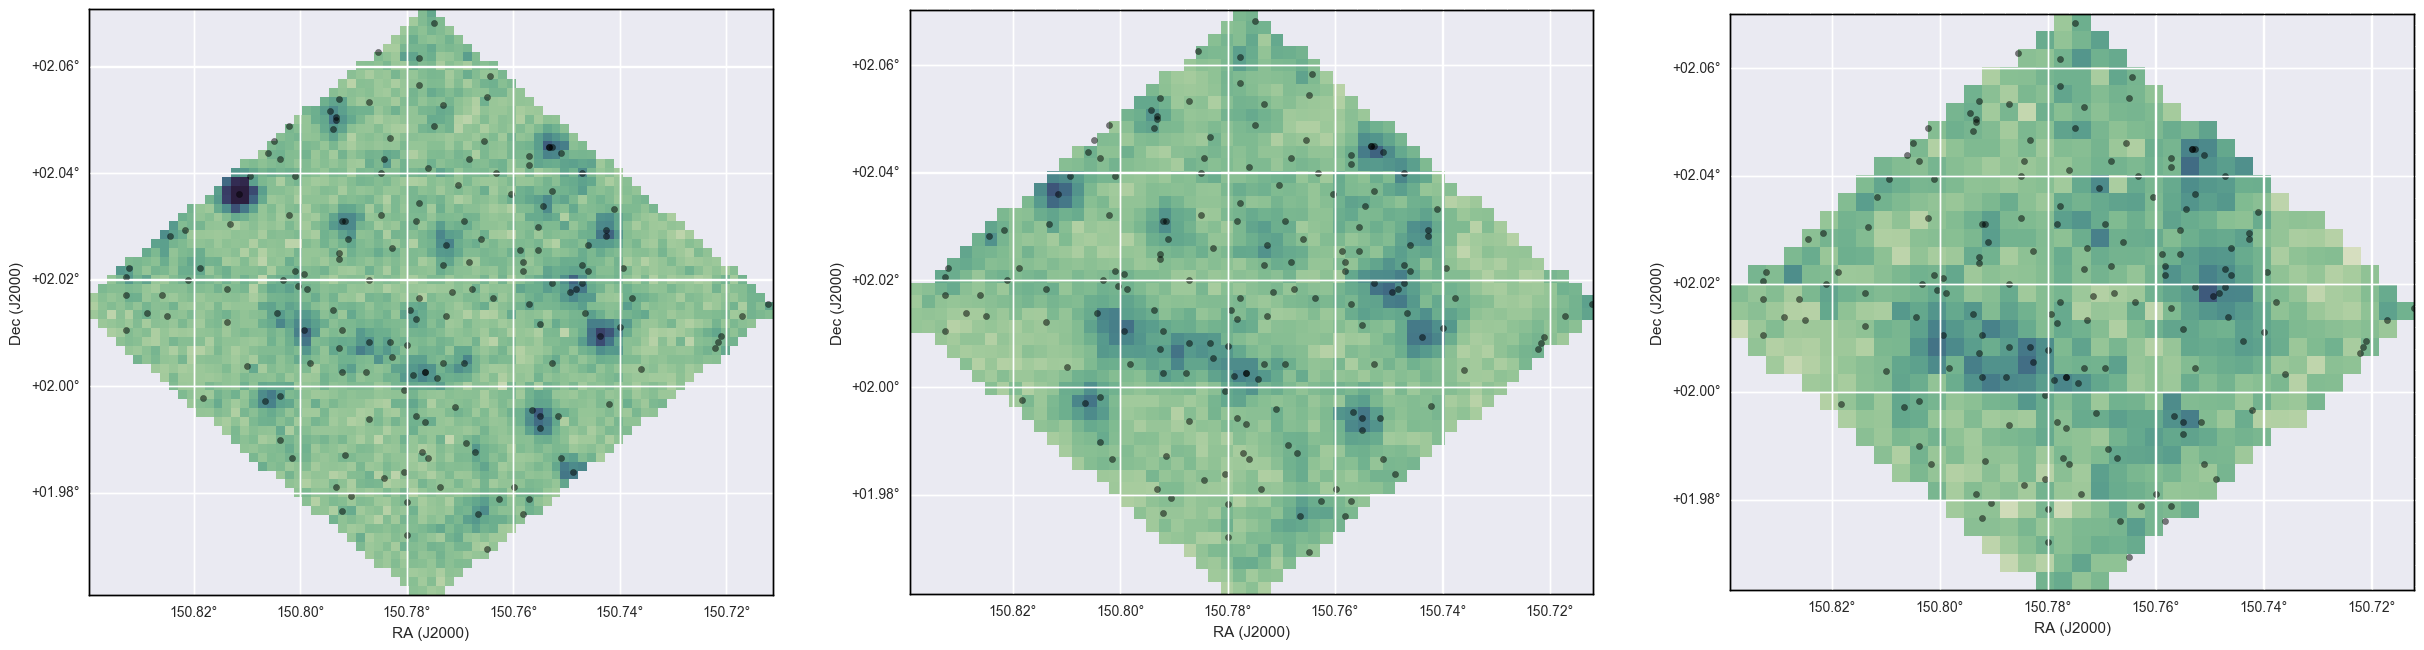

In [6]:
import aplpy
fig = plt.figure(figsize=(30,10))
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
real_350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_350.tick_labels.set_xformat('dd.dd')
real_350.tick_labels.set_yformat('dd.dd')
real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
real_500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_500.tick_labels.set_xformat('dd.dd')
real_500.tick_labels.set_yformat('dd.dd')


### Posterior replicated data

We can use each sample we have from the posterior, and use it to make a replicated map, including simulating the instrumental noise, and the estimated confusion noise. You can think of these maps as all the possible maps that are allowed by the data. 

In [7]:
mod_map=np.full((hdulist_250[1].data.shape[1],hdulist_250[1].data.shape[0],500),np.nan)
mod_map_array=np.empty((prior250.snpix,500))

for i in range(0,500):
    mod_map_array[:,i]= postmaps.ymod_map(prior250,posterior.stan_fit[i,0,0:prior250.nsrc]).reshape(-1)+posterior.stan_fit[i,0,prior250.nsrc]+np.random.normal(scale=np.sqrt(prior250.snim**2+posterior.stan_fit[i,0,(prior250.nsrc+1)*3]**2))         
    mod_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array[:,i]

In [8]:
mod_map_350=np.full((hdulist_350[1].data.shape[1],hdulist_350[1].data.shape[0],500),np.nan)
mod_map_array_350=np.empty((prior350.snpix,500))

for i in range(0,500):
    mod_map_array_350[:,i]= postmaps.ymod_map(prior350,posterior.stan_fit[i,0,prior350.nsrc+1:2*prior350.nsrc+1]).reshape(-1)+posterior.stan_fit[i,0,2*prior350.nsrc+1]+np.random.normal(scale=np.sqrt(prior350.snim**2+posterior.stan_fit[i,0,1+(prior350.nsrc+1)*3]**2))         
    mod_map_350[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array_350[:,i]

In [9]:

mod_map_500=np.full((hdulist_500[1].data.shape[1],hdulist_500[1].data.shape[0],500),np.nan)
mod_map_array_500=np.empty((prior500.snpix,500))

for i in range(0,500):
    mod_map_array_500[:,i]= postmaps.ymod_map(prior500,posterior.stan_fit[i,0,2*prior500.nsrc+2:3*prior350.nsrc+2]).reshape(-1)+posterior.stan_fit[i,0,3*prior500.nsrc+2]+np.random.normal(scale=np.sqrt(prior500.snim**2+posterior.stan_fit[i,0,2+(prior500.nsrc+1)*3]**2))         
    mod_map_500[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array_500[:,i]

The easiest way to visualise the replicated maps is to create animations. We can do this in the notebook by defining the following functions:

In [10]:
from tempfile import NamedTemporaryFile
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
from IPython.display import HTML


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

Now lets use these functions, and use the original maps as a basis figure, where each frame one of the replicated maps.

In [11]:

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(30,10))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res250.tick_labels.set_xformat('dd.dd')
res250.tick_labels.set_yformat('dd.dd')

res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res350.tick_labels.set_xformat('dd.dd')
res350.tick_labels.set_yformat('dd.dd')

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res500.tick_labels.set_xformat('dd.dd')
res500.tick_labels.set_yformat('dd.dd')


# animation function.  This is called sequentially
def animate(i):
    res250._data=mod_map[:,:,i].T
    res350._data=mod_map_350[:,:,i].T
    res500._data=mod_map_500[:,:,i].T

    res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)


    return [res250,res350,res500]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=50, interval=1000)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

Lets Zoom in!!

In [17]:
from astropy.coordinates import SkyCoord
from astropy import units as u
ra_zoom=150.742
dec_zoom=2.03

radius=0.01
c = SkyCoord(ra=ra_zoom*u.degree, dec=dec_zoom*u.degree)  
catalog = SkyCoord(ra=prior250.sra*u.degree, dec=prior250.sdec*u.degree)  
ind=c.separation(catalog)<0.01*u.deg

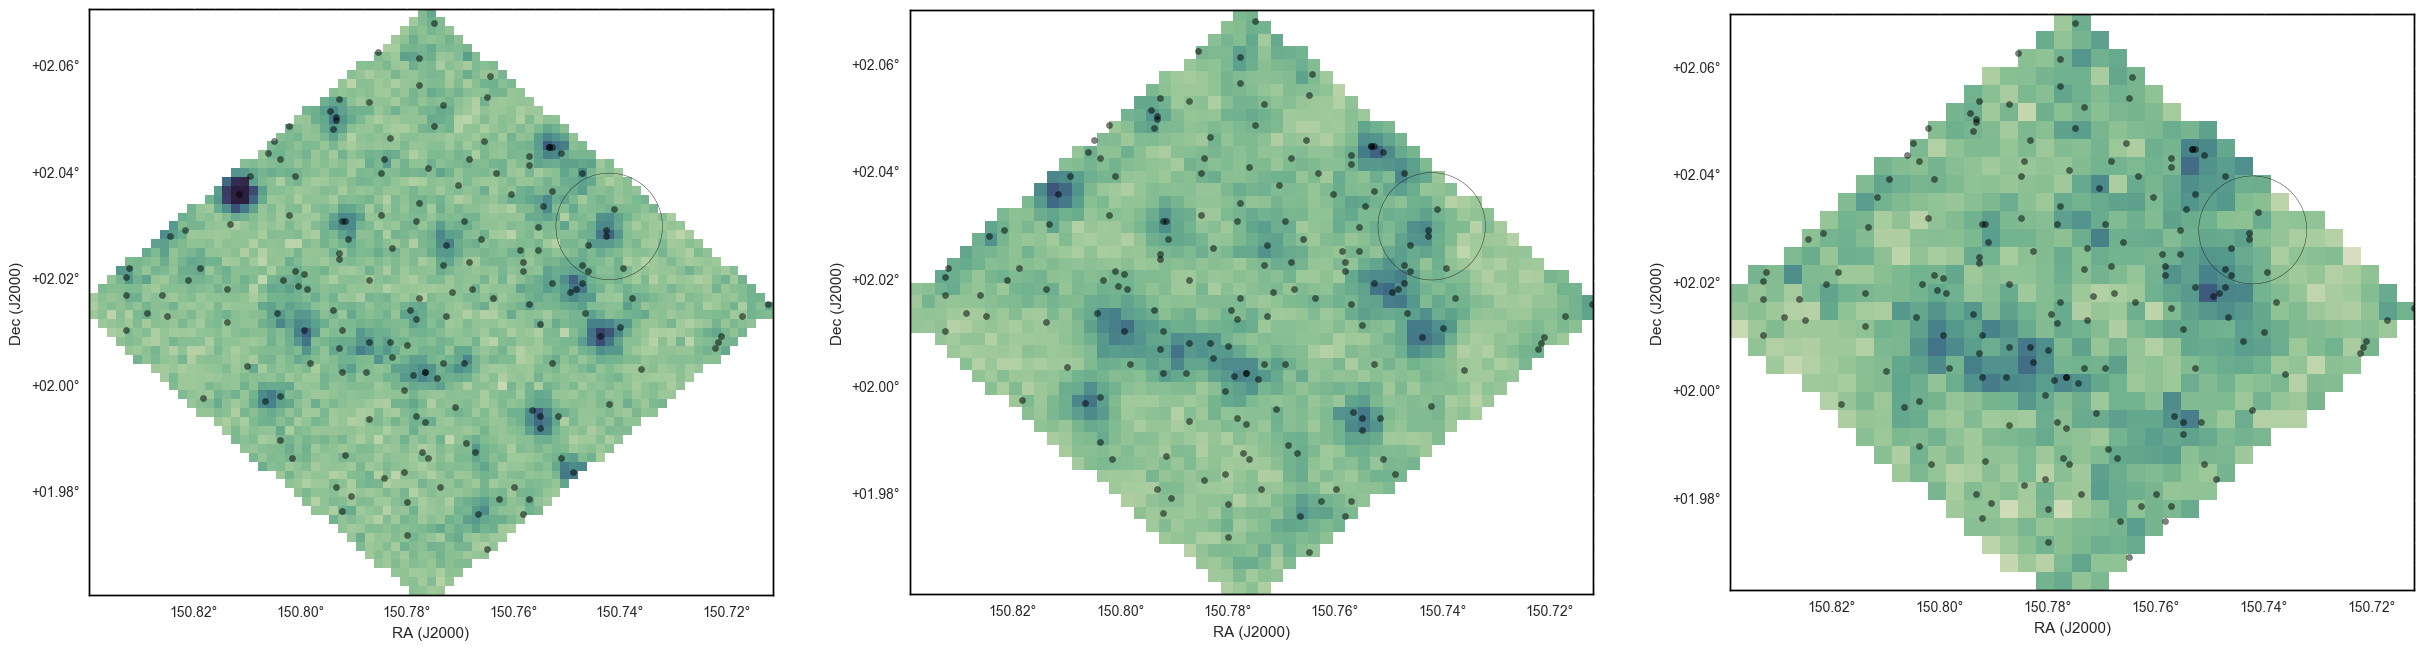

In [18]:
fig = plt.figure(figsize=(30,10))
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')
real_250.show_circles(ra_zoom,dec_zoom, radius)
real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
real_350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_350.show_circles(ra_zoom,dec_zoom, radius)
real_350.tick_labels.set_xformat('dd.dd')
real_350.tick_labels.set_yformat('dd.dd')

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
real_500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_500.show_circles(ra_zoom,dec_zoom, radius)
real_500.tick_labels.set_xformat('dd.dd')
real_500.tick_labels.set_yformat('dd.dd')




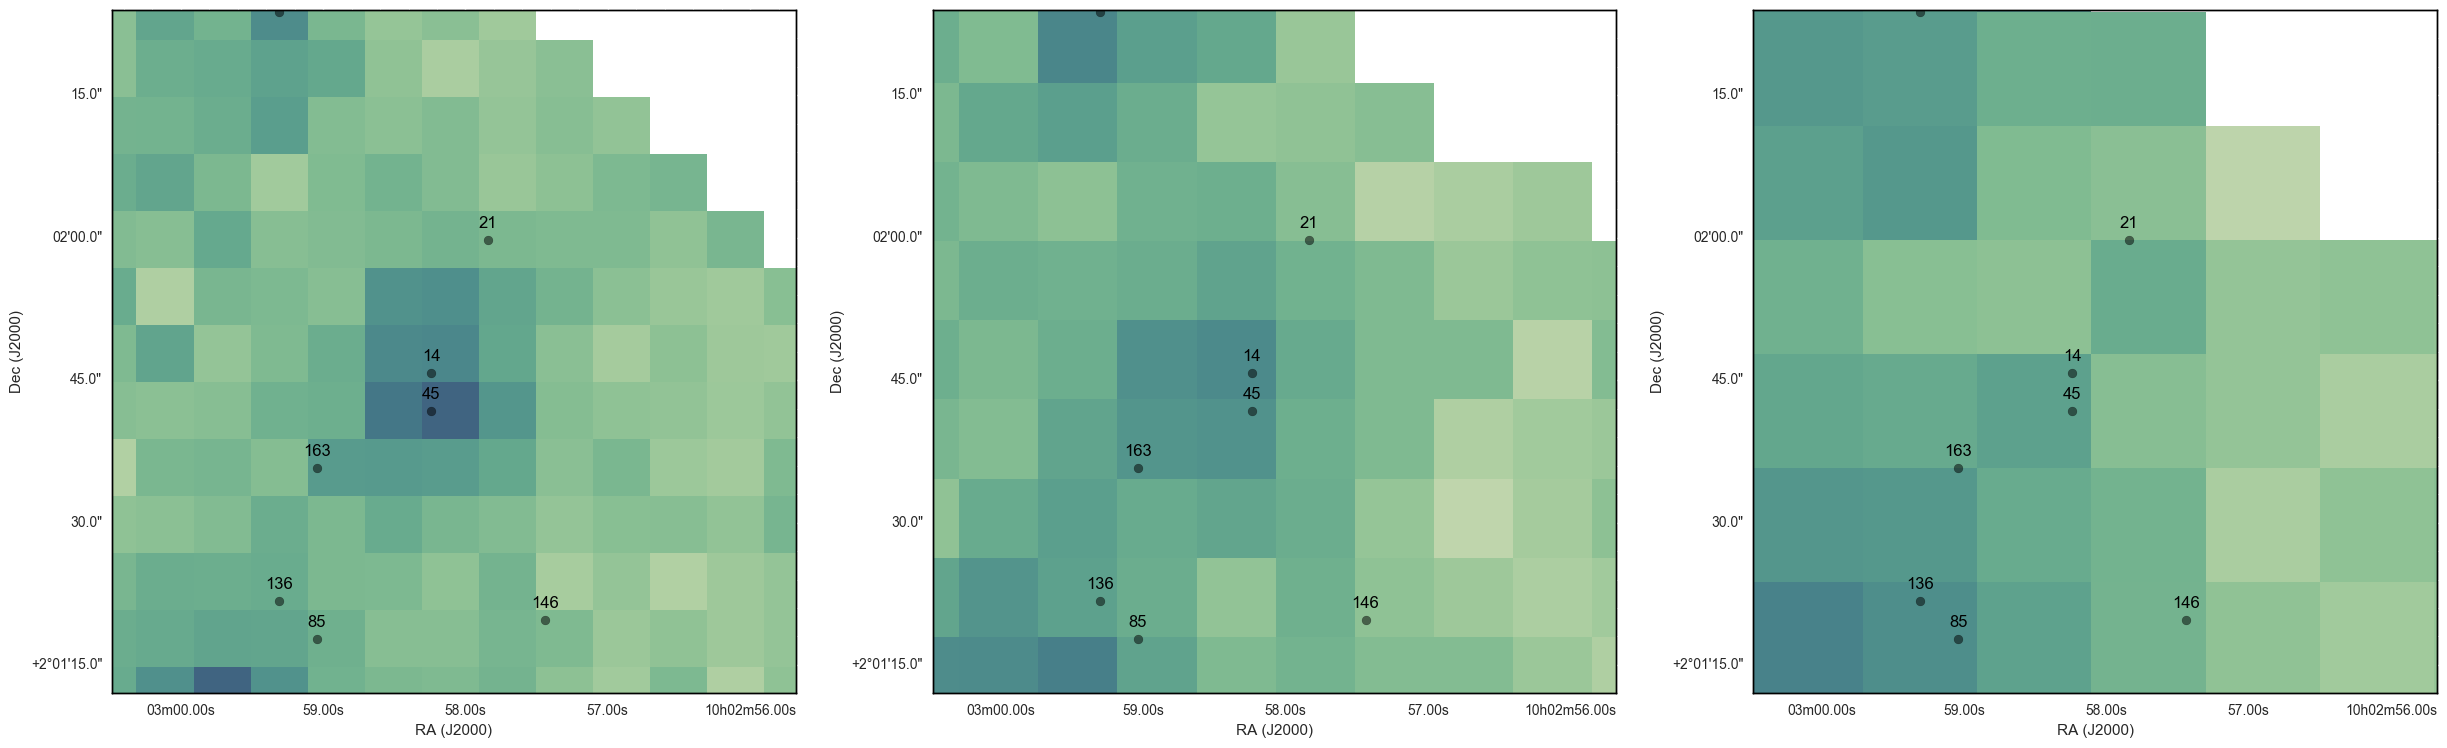

In [19]:
fig = plt.figure(figsize=(30,10))
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)


real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
real_350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)

real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_350.recenter(ra_zoom, dec_zoom, radius=radius)

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
real_500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_500.recenter(ra_zoom, dec_zoom, radius=radius)

for i in range(0,prior250.sra[ind].size):

    real_250.add_label(prior250.sra[ind][i], prior250.sdec[ind][i]+0.0005, np.arange(0,prior250.nsrc)[ind][i], relative=False)
    real_350.add_label(prior250.sra[ind][i], prior250.sdec[ind][i]+0.0005, np.arange(0,prior250.nsrc)[ind][i], relative=False)
    real_500.add_label(prior250.sra[ind][i], prior250.sdec[ind][i]+0.0005, np.arange(0,prior250.nsrc)[ind][i], relative=False)

In [20]:
#Select source you want to plot joint distribution
s1=14
s2=45

 We can see that sources 68 and 5 are close together, lets look at their joint posterior probabiity distribution. The code below plots the 1,2 and 3 sigma contours for the joint posterior, and an inset of the real map.

[0.0003468055897878401, 0.0013872223623004921, 0.005895695038989809, 0.018033890706757268]


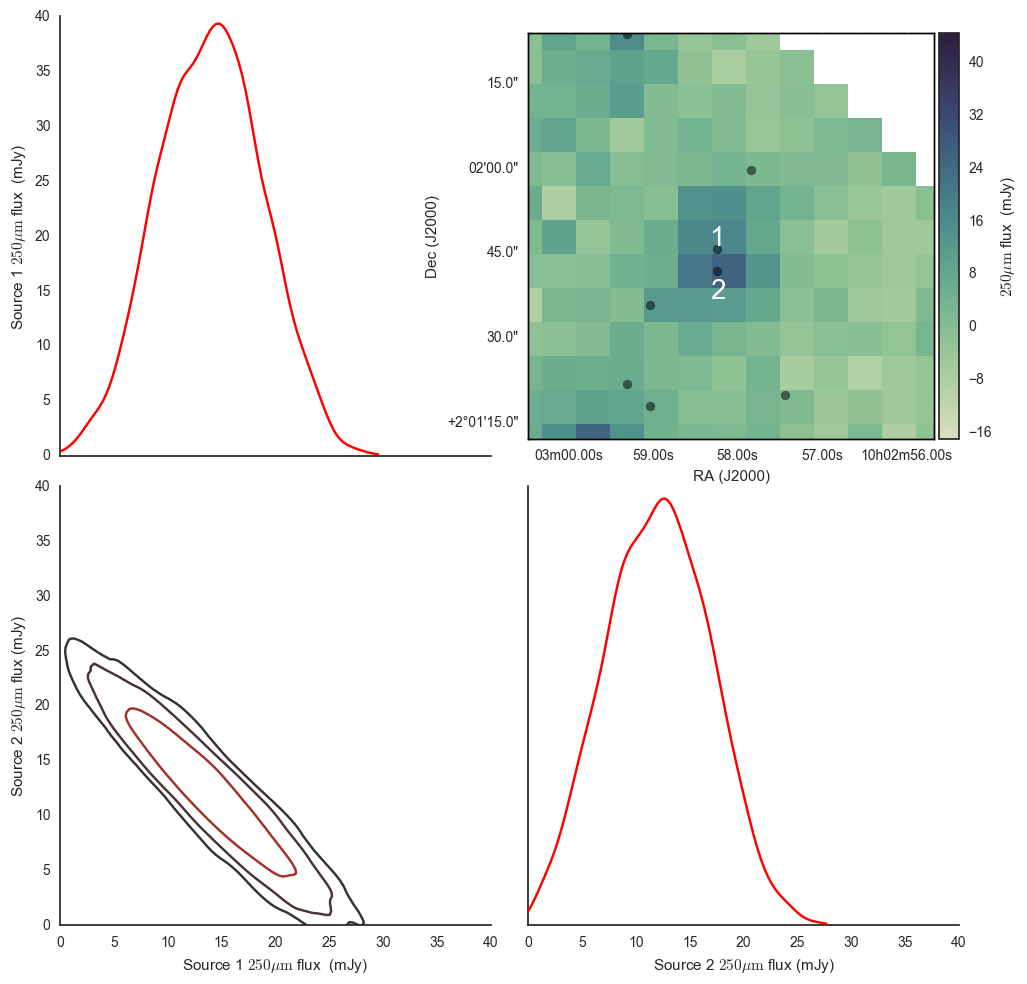

In [21]:
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")


import scipy
# Make a 2d normed histogram
H,xedges,yedges=np.histogram2d(posterior.stan_fit[:,:,[s1]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),posterior.stan_fit[:,:,[s2]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process
def objective(limit, target):
    w = np.where(H>limit)
    count = H[w]
    return count.sum() - target

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior.stan_fit[:,:,[s1,s2]].reshape(3000,2),columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=1.0,n_levels=levels,normed=True)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)

real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)

real_250.add_label(prior250.sra[s1], prior250.sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(prior250.sra[s2], prior250.sdec[s2]-0.0010, 2, relative=False,size=20,color='white')



real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')  


## Bayesian P-value maps

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way. 

For one pixel, we can look at where the real flux in the map is in comparison to the distribution from $y^{rep}$

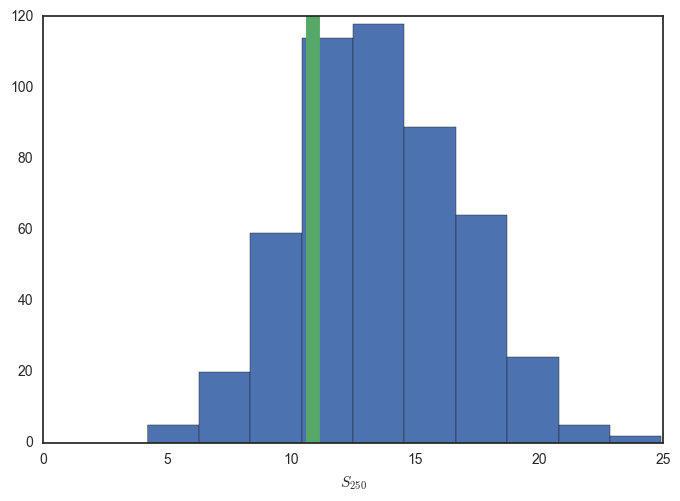

In [26]:
plt.hist(mod_map[50,50,:].T)
plt.axvline(hdulist_250[1].data[50,50],color='g',linewidth=10)
plt.xlabel(r'$S_{250}$')

We can calculate fraction of $y^{rep}$ samples above and below real map value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real pixel value, from our model which has been inferred on the data. This is basically telling us if the model is missing something.

$\approx 0.5$ means nothing going on

0.99 or 0.01 means model is missing something

We can create map versions of these Bayesian p-values:

In [27]:
import scipy.stats as st

pval_250=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array[i,:]<prior250.sim[i]
    pval_250[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array.shape[1]))
pval_250[np.isposinf(pval_250)]=6
    
pval_350=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350[i,:]<prior350.sim[i]
    pval_350[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350.shape[1]))
pval_350[np.isposinf(pval_350)]=6
    
pval_500=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500[i,:]<prior500.sim[i]
    pval_500[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500.shape[1]))
pval_500[np.isposinf(pval_500)]=6

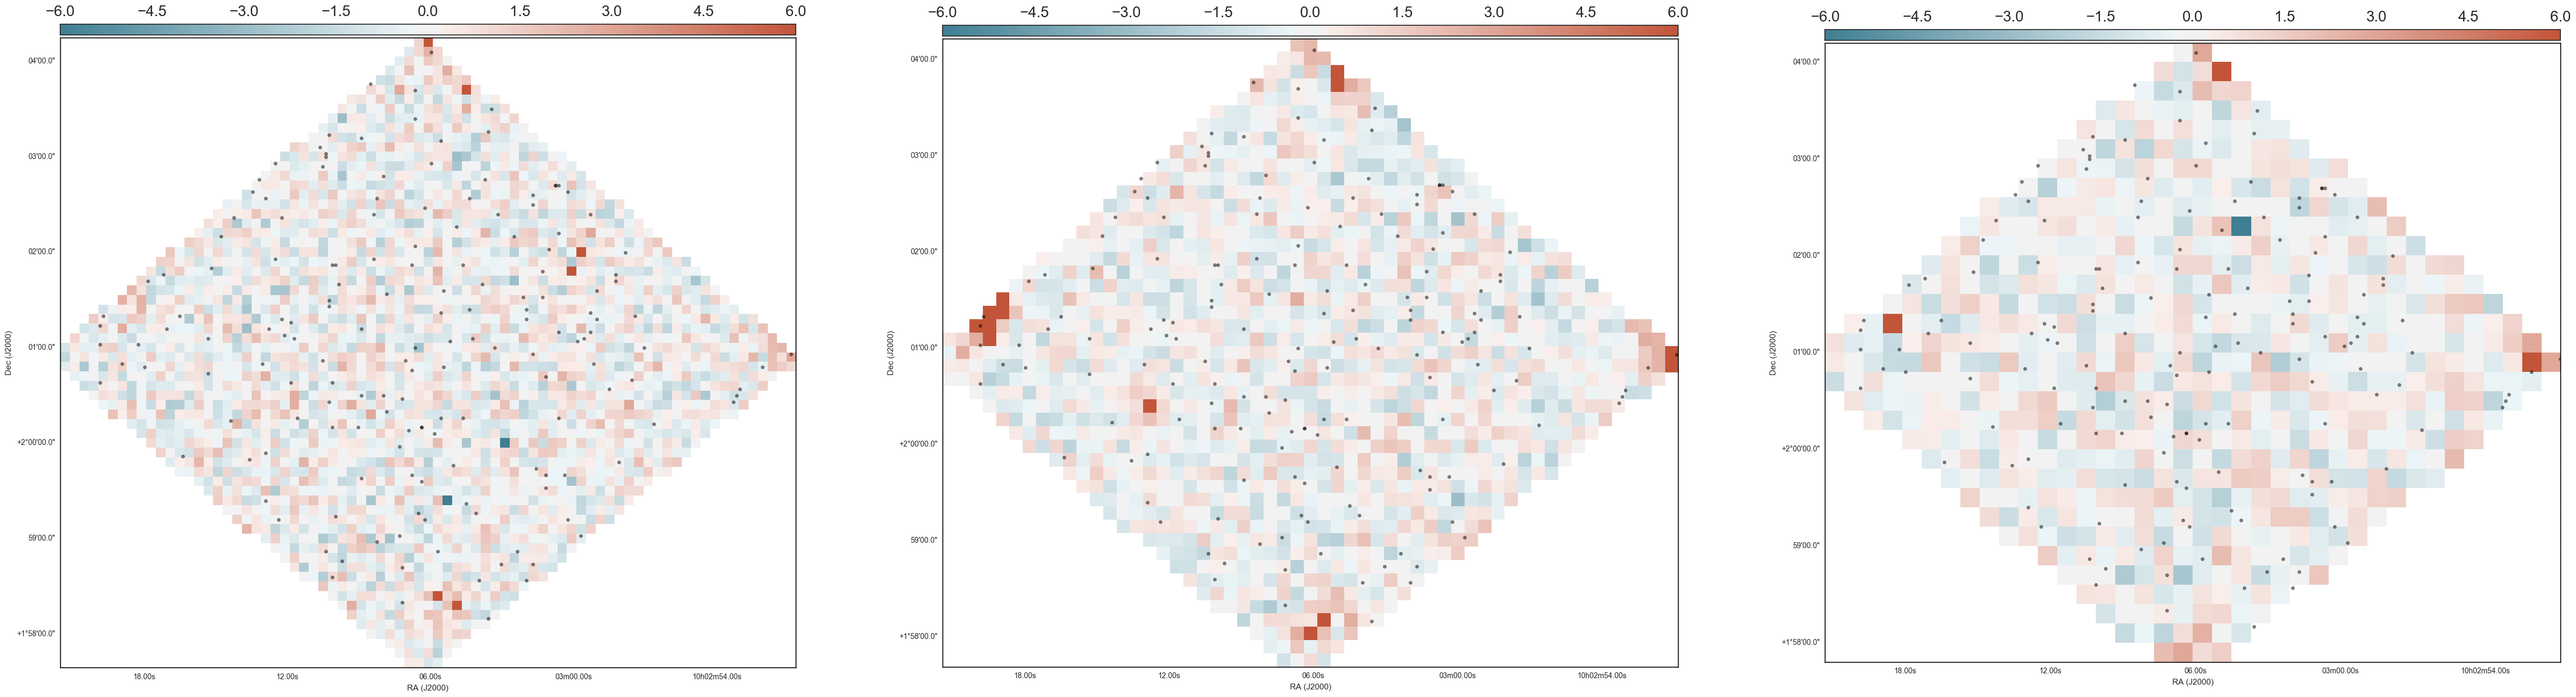

In [28]:
vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)
from pylab import rcParams
rcParams.update({'font.size': 20})

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(60,20))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)


res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500



res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')



Red indicates the flux value in the real map is higher than our model thinks is possible. This could be indicating there is a source there that is not in our model.
Blue indicates the flux in the real map is lower than in our model. This is either indicating a very low density region or that too much flux has been assigned to one of the sources.

Because this run is based on a simulation, we can look at what is really happening. Lets load up the simulated catalogue and plot the sources that were not in our prior list

In [29]:
#Folder containing prior input catalogue
folder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'
from astropy.io import fits
hdulist = fits.open(folder+prior_cat)
truth_orig=hdulist[1].data
hdulist.close()


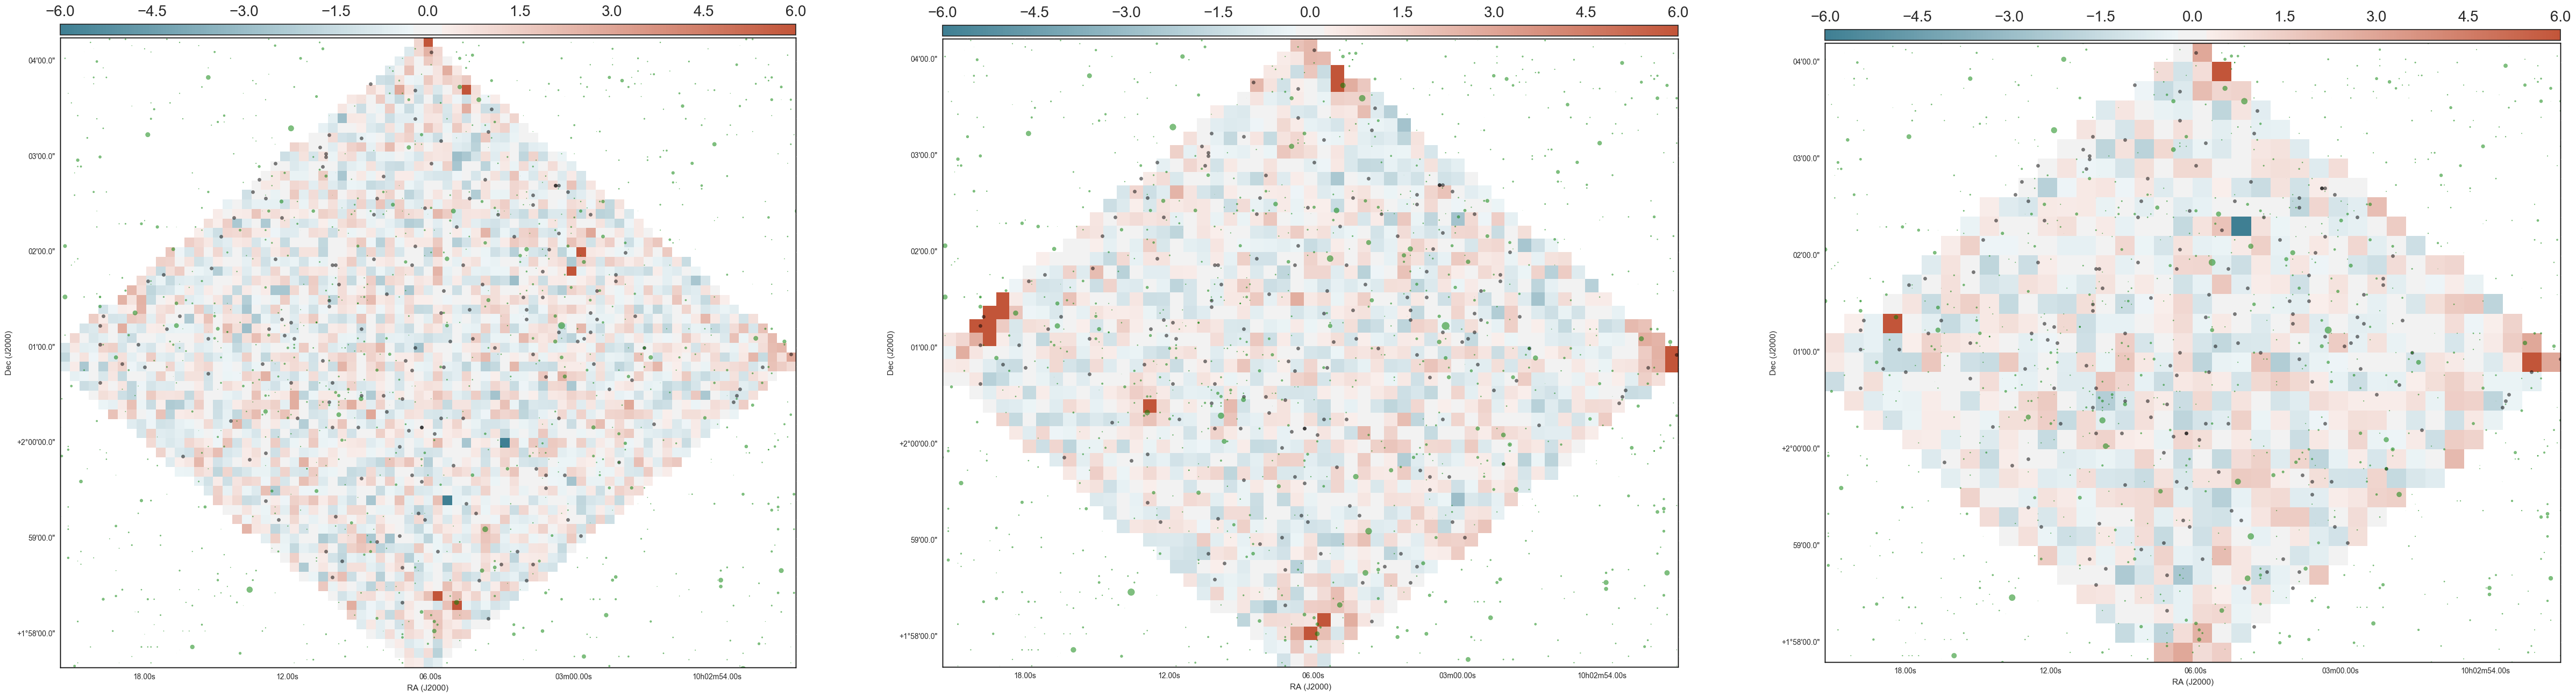

In [31]:
vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(60,20))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res250.show_markers(truth_orig['RA'][truth_orig['S100'] <0.050],truth_orig['DEC'][truth_orig['S100'] <0.050], edgecolor='green', facecolor='green',
                marker='o', s=10*truth_orig['S250'][truth_orig['S100'] <0.050], alpha=0.5)
#res250.recenter(ra_zoom, dec_zoom, radius=radius)



res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res350.show_markers(truth_orig['RA'][truth_orig['S100'] <0.050],truth_orig['DEC'][truth_orig['S100'] <0.050], edgecolor='green', facecolor='green',
                marker='o', s=10*truth_orig['S350'][truth_orig['S100'] <0.050], alpha=0.5)
#res350.recenter(ra_zoom, dec_zoom, radius=radius)


res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res500.show_markers(truth_orig['RA'][truth_orig['S100'] <0.050],truth_orig['DEC'][truth_orig['S100'] <0.050], edgecolor='green', facecolor='green',
                marker='o', s=10*truth_orig['S500'][truth_orig['S100'] <0.050], alpha=0.5)
#res500.recenter(ra_zoom, dec_zoom, radius=radius)

res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500



res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')



As can be seen, where there is a p-value with a high significance (i.e. > 3 sigma) there is a either quite a few sources close together, or a bright source that is not in the prior list.